In [1]:
import re
import random
import textwrap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import comb, factorial
from numpy.random import choice, rand
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.stats import beta, poisson, gaussian_kde, norm
plt.rcParams['figure.figsize'] = [10, 8]

### Завдання 1, лекція 5

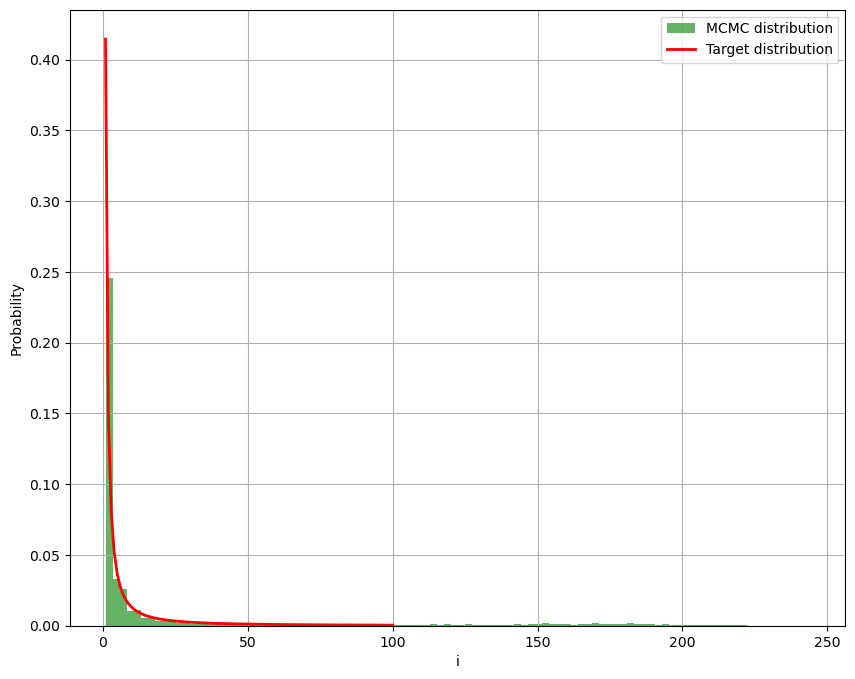

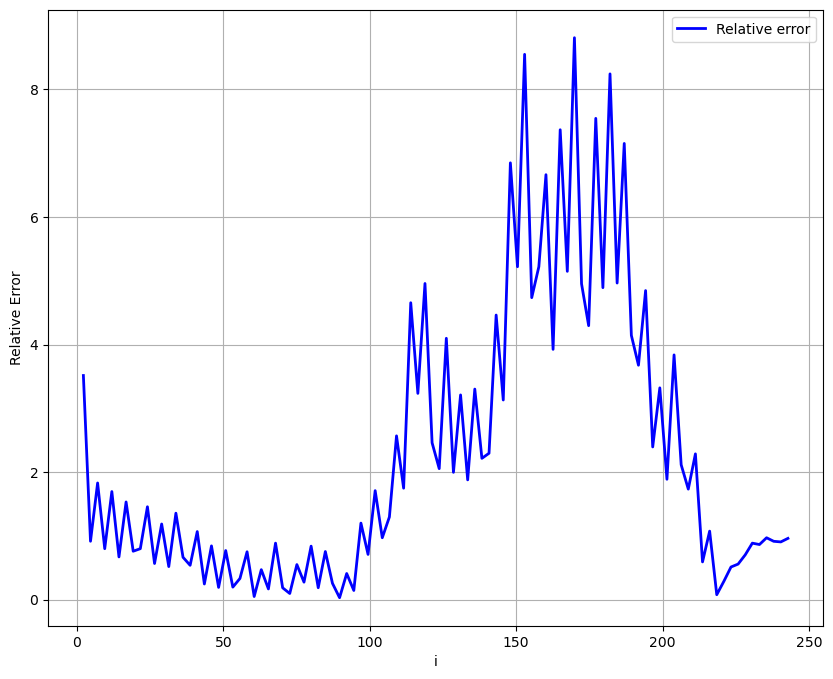

In [4]:
n = 10**6

def target_distribution(i):
    return i ** (-3/2)

def metropolis_hastings(n, c):
    samples = []
    current_i = np.random.randint(1, c + 1)

    for _ in range(n):
        proposed_i = current_i + np.random.randint(-1, 2)
        
        if proposed_i < 1:
            proposed_i = 1 
        
        acceptance_ratio = target_distribution(proposed_i) / target_distribution(current_i)
        
        if np.random.rand() < acceptance_ratio:
            current_i = proposed_i
        
        samples.append(current_i)
    
    return np.array(samples)

samples = metropolis_hastings(n, c=100)

i_values = np.arange(1, 101)
target_probs = target_distribution(i_values)
target_probs /= np.sum(target_probs)

plt.hist(samples, bins=100, density=True, alpha=0.6, color='g', label='MCMC distribution')
plt.plot(i_values, target_probs, 'r-', lw=2, label='Target distribution')
plt.xlabel('i')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

hist, bin_edges = np.histogram(samples, bins=100, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
mcmc_probs = hist / np.sum(hist)

target_interp = np.interp(bin_centers, i_values, target_probs)

relative_error = np.abs(mcmc_probs - target_interp) / target_interp

plt.plot(bin_centers, relative_error, 'b-', lw=2, label='Relative error')
plt.xlabel('i')
plt.ylabel('Relative Error')
plt.grid(True)
plt.legend()
plt.show()


Перший графік відображає різницю між побудованим розподілом та аналітичним. \
Другий графік візуалізує відносну різниця між MCMC і аналітичним розподілами.

### Завдання 2, лекція 5

In [14]:
def count_chars_and_words(path):
    with open(path, 'r', encoding='utf-8') as file:
        text = file.read()
    char_count = len(text)
    word_count = len(text.split())
    return char_count, word_count

input_chars, input_words = count_chars_and_words('input.txt')
print(f'Input.txt: {input_chars} characters, {input_words} words')

train_chars, train_words = count_chars_and_words('train.txt')
print(f'Train.txt: {train_chars} characters, {train_words} words')

Input.txt: 5619 characters, 1004 words
Train.txt: 14564 characters, 2614 words


In [13]:
def preprocess_text(path_book):
    with open(path_book, 'r', encoding='utf-8') as file:
        text = file.read()
    alphabet = 'abcdefghijklmnopqrstuvwxyz '
    text = text.lower().replace('\n', ' ')
    text = ''.join([char if char in alphabet else '' for char in text])
    text = " ".join(text.split())
    return text

def create_v_matrix(text):
    alphabet = 'abcdefghijklmnopqrstuvwxyz '
    alph_len = len(alphabet)
    v_matrix = np.ones((alph_len, alph_len), dtype='uint')
    for i in range(alph_len):
        for j in range(alph_len):
            pattern = alphabet[i] + alphabet[j]
            v_matrix[i, j] += len(re.findall(f'(?={re.escape(pattern)})', text))
    return v_matrix

def code_and_decode_text(ordinary_text, M):
    alphabet = list('abcdefghijklmnopqrstuvwxyz ')
    coded_alphabet = alphabet.copy()
    random.shuffle(coded_alphabet)
    
    coded_text = ''.join([coded_alphabet[alphabet.index(char)] for char in ordinary_text])

    coded_text_numbers = np.array([alphabet.index(char) for char in coded_text], dtype='uint')
    f = np.arange(len(alphabet))

    with open('output.txt', 'w', encoding='utf-8') as file:
        save_decoded_text(0, f, coded_text_numbers, file)
        for epoch in range(20000):
            f_new = swap_random_elements(f)
            if (epoch + 1) % 500 == 0:
                save_decoded_text(epoch + 1, f, coded_text_numbers, file)
            a_f_f_new = calculate_alpha(f, f_new, coded_text_numbers, M)
            if np.random.rand() <= a_f_f_new:
                f = f_new.copy()
        save_decoded_text(epoch + 1, f, coded_text_numbers, file)

    return ''.join([alphabet[num] for num in f_code(f, coded_text_numbers)])

def swap_random_elements(f):
    f_new = f.copy()
    idx1, idx2 = np.random.choice(len(f), 2, replace=False)
    f_new[idx1], f_new[idx2] = f_new[idx2], f_new[idx1]
    return f_new

def calculate_alpha(f, f_new, coded_text, M):
    old_decoded = f_code(f, coded_text)
    new_decoded = f_code(f_new, coded_text)
    score = 1.0
    for k in range(len(old_decoded) - 1):
        i_old, j_old = old_decoded[k], old_decoded[k + 1]
        i_new, j_new = new_decoded[k], new_decoded[k + 1]
        if M[i_new, j_new] == 0:
            M[i_new, j_new] = 1
        score *= M[i_new, j_new] / M[i_old, j_old]
    return min(1, score)

def f_code(f, coded_text):
    return np.array([f[char] for char in coded_text])

def save_decoded_text(epoch, f, coded_text, file):
    if epoch == 0:
        file.write('CODED TEXT\n')
    else:
        file.write(f'EPOCH {epoch}\n')
    decoded_text = ''.join([chr(97 + num) if num < 26 else ' ' for num in f_code(f, coded_text)])
    wrapped_string = textwrap.fill(decoded_text, width=80)
    file.write(wrapped_string + '\n\n')

path_train = 'train.txt'
train_text = preprocess_text(path_train)

v_matrix = create_v_matrix(train_text)

path_input = 'input.txt'
input_text = preprocess_text(path_input)

decoded_text = code_and_decode_text(input_text, v_matrix)

/tmp/ipykernel_4191/819967420.py:58: RuntimeWarning: overflow encountered in scalar multiply
  score *= M[i_new, j_new] / M[i_old, j_old]


Для виконання цього завдання я обрав дві книги Charles Dickens : "Bleak House" та "A Tale of Two Cities" . Мова оригіналу.\
Для тренування використана книга "Bleak House". Це файл "train.txt". \
Для дешифрування відповідно друга книга. Текст міститься у файлі "input.txt".\
Результат дешифрування можна знайти в файлі "output.txt". \
Загалом для такого об'єму слів мені знадобилось >= 15000 ітерацій. Для більшого об'єму потрібно буде або збільшувати кількість ітерацій, або покращувати алгоритм дешифрування.

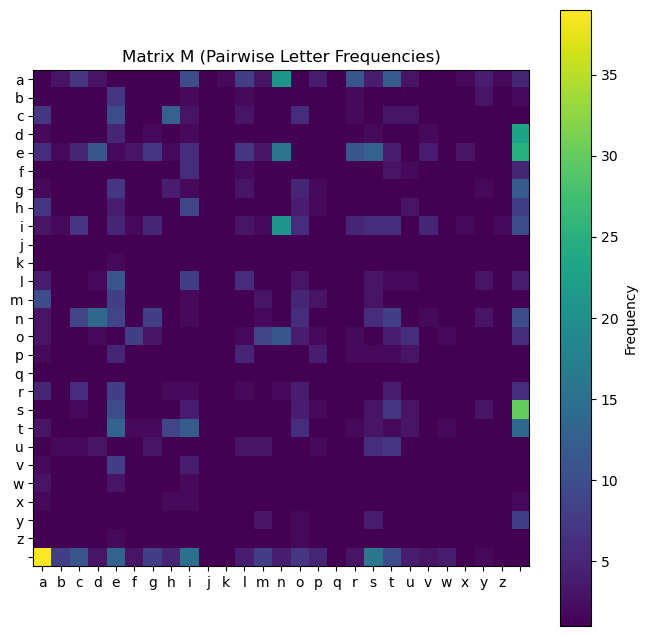

In [15]:
def display_matrix(M):
    plt.figure(figsize=(8, 8))
    plt.imshow(M, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Frequency')
    plt.title("Matrix M (Pairwise Letter Frequencies)")
    
    alphabet = list('abcdefghijklmnopqrstuvwxyz ')
    plt.xticks(ticks=np.arange(len(alphabet)), labels=alphabet)
    plt.yticks(ticks=np.arange(len(alphabet)), labels=alphabet)
    
    plt.show()

display_matrix(v_matrix)

Heatmap кореляції частоти зустрічи букв. 

### Завдання 3, лекція 6

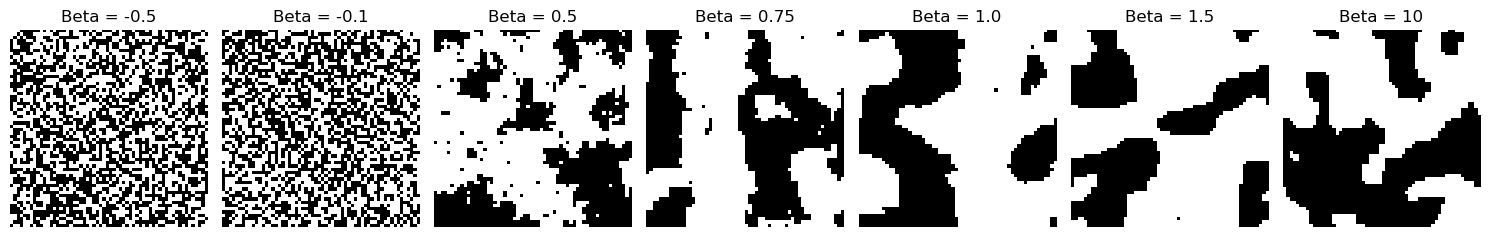

In [6]:
L = 60
T = 100000
beta_values = [-0.5, -0.1, 0.5, 0.75, 1.0, 1.5, 10]

def delta_E(spins, i, j):
    spin = spins[i, j]
    neighbors_sum = (spins[(i+1) % L, j] + spins[(i-1) % L, j] + 
                     spins[i, (j+1) % L] + spins[i, (j-1) % L])
    return 2 * spin * neighbors_sum

def initialize_spins(L):
    return np.random.choice([-1, 1], size=(L, L))

def metropolis(spins, beta):
    for _ in range(T):
        i, j = np.random.randint(0, L, size=2)
        dE = delta_E(spins, i, j)
        if dE < 0 or np.random.rand() < np.exp(-beta * dE):
            spins[i, j] *= -1

fig, axes = plt.subplots(1, len(beta_values), figsize=(15, 8))

for idx, beta in enumerate(beta_values):
    spins = initialize_spins(L)
    metropolis(spins, beta)
    axes[idx].imshow(spins, cmap='grey')
    axes[idx].set_title(f'Beta = {beta}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Створюється ряд графіків для кожного значення $\beta$ з умови. \
Для кожного значення $\beta$ ініціалізуються спіни та виконується метод Метрополіса. \
Результат (ґратка спінів) відображається на графіку з використанням функції imshow(). 

### Завдання 4, лекція 6

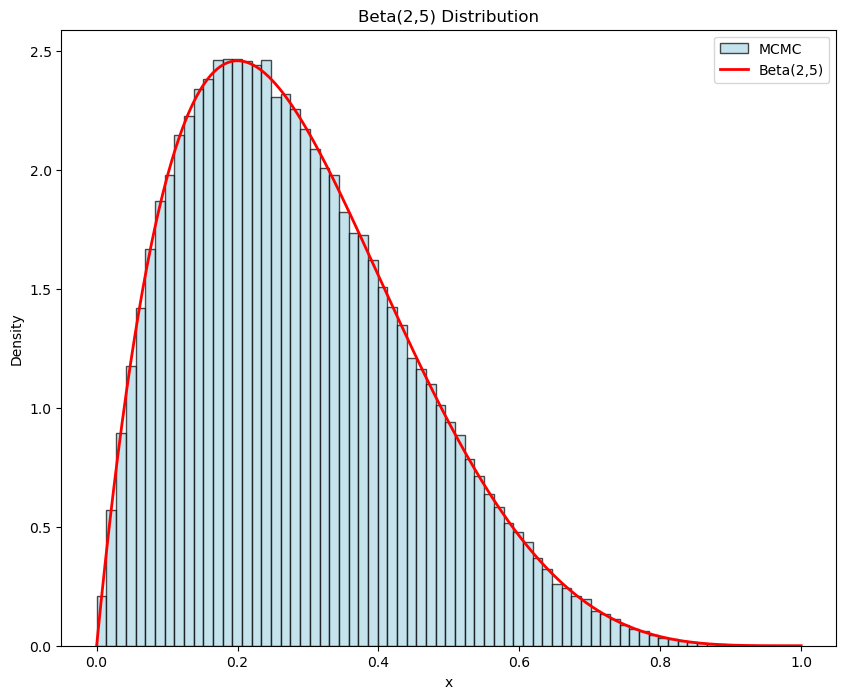

In [7]:
from scipy.stats import beta

def beta_distribution_mh(a, b, n, burn_in):
    X = np.zeros(n)
    X[0] = np.random.rand()

    for i in range(1, n):
        candidate = np.random.rand()
        acceptance_ratio = min(beta_density(a, b, candidate) / beta_density(a, b, X[i-1]), 1)
        
        if np.random.rand() < acceptance_ratio:
            X[i] = candidate
        else:
            X[i] = X[i-1]

    return X[burn_in:]

def beta_density(a, b, x):
    if 0 < x < 1:
        return x**(a-1) * (1-x)**(b-1)
    else:
        return 0

def plot_histogram(samples, bins, a, b):
    plt.hist(samples, bins=bins, density=True, color='lightblue', edgecolor='black', alpha=0.7, label='MCMC')
    
    x = np.linspace(0, 1, 1000)
    plt.plot(x, beta.pdf(x, a, b), 'r-', lw=2, label=f'Beta({a},{b})')
    
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title(f'Beta({a},{b}) Distribution')
    plt.legend()
    plt.show()

a, b = 2, 5
n_samples = 700000
burn_in = 3000
bins = 70

samples = beta_distribution_mh(a, b, n_samples, burn_in)

plot_histogram(samples, bins, a, b)

Графік дозволяє наочно побачити, як працює MCMC для отримання вибірки з бета-розподілу в порівнянні з аналітичним розподілом Beta(2, 5).

### Завдання 5, лекція 6

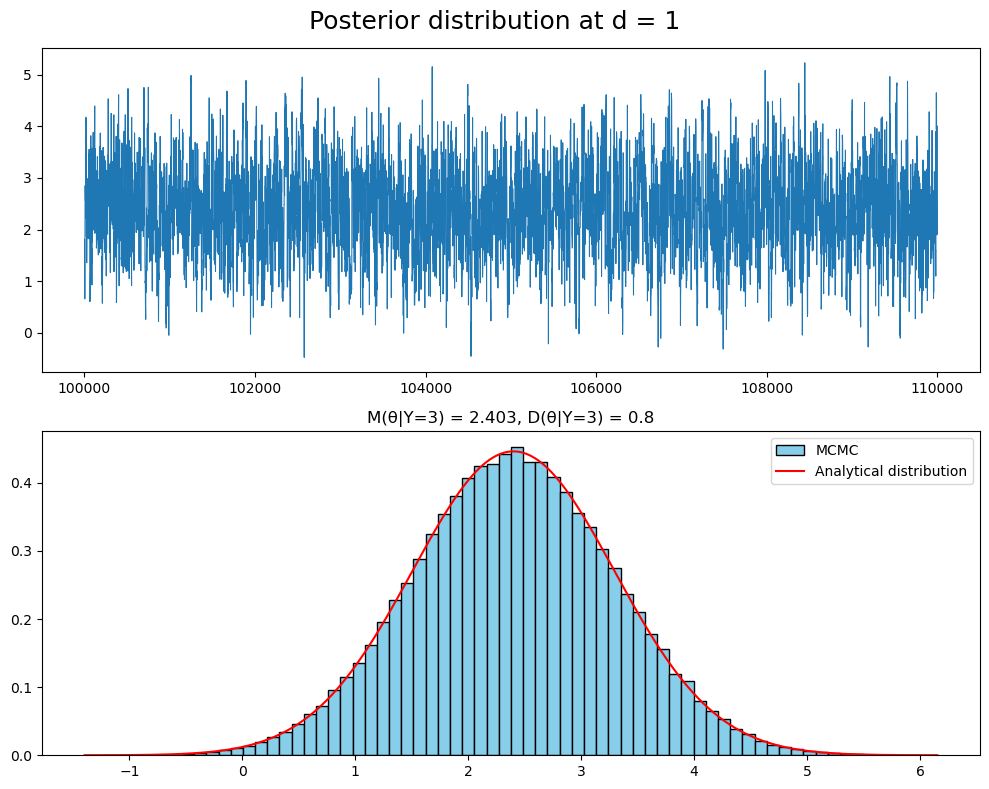

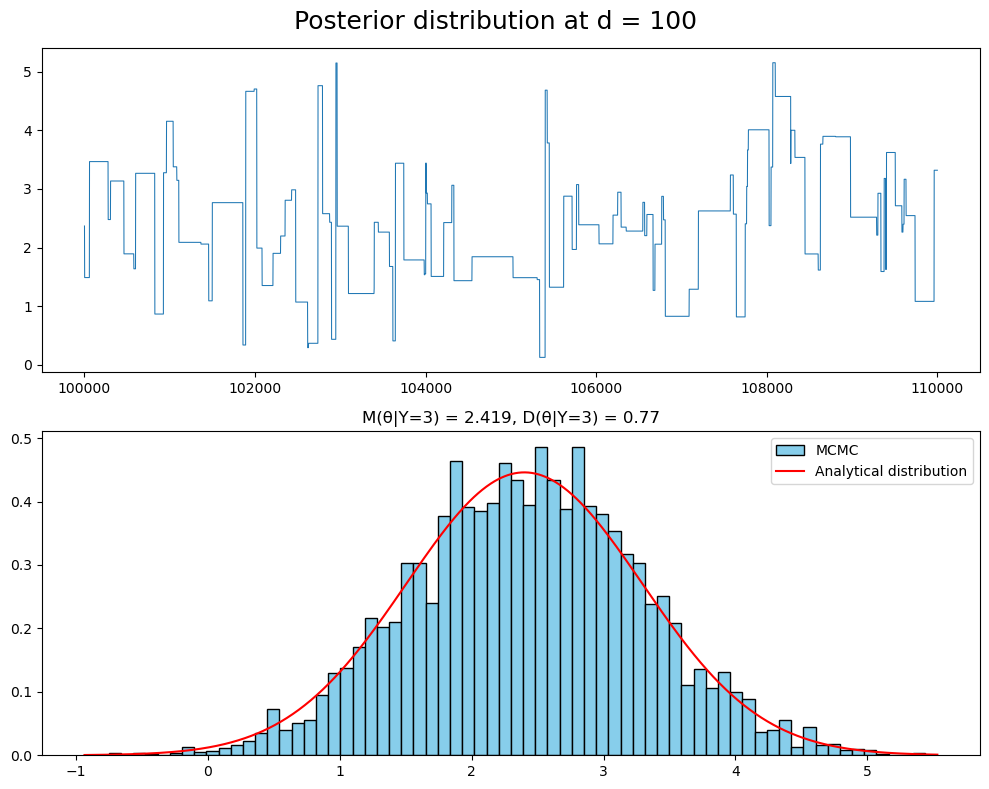

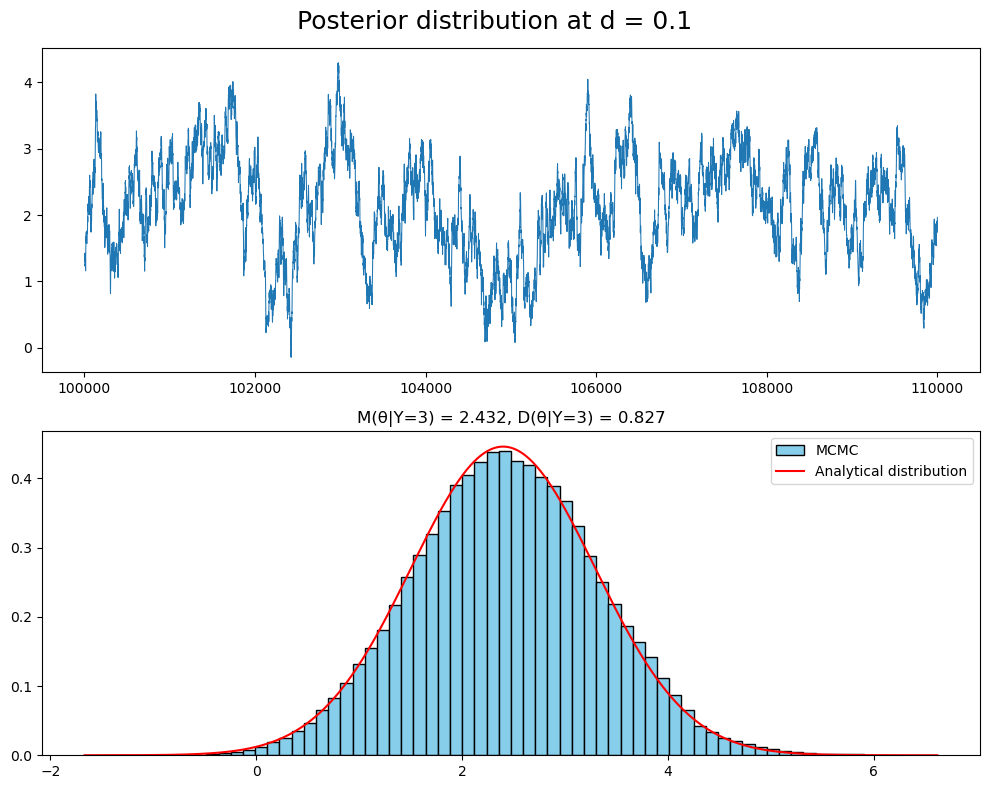

In [8]:
def mcmc_apostr_norm(n, d, y, mu, tau2, sigma2):
    X = np.zeros(n)
    X[0] = np.random.normal(mu, np.sqrt(tau2))
    for i in range(1, n):
        eps = np.random.normal(0, d)
        x_new = X[i - 1] + eps
        alpha = min(apostr_ratio(X[i - 1], x_new, y, mu, tau2, sigma2), 1)
        u = np.random.rand()
        X[i] = x_new if u <= alpha else X[i - 1]
    return X

def apostr_norm_analytical(y, mu, tau2, sigma2):
    a = ((1 / sigma2) / (1 / sigma2 + 1 / tau2)) * y + ((1 / tau2) / (1 / sigma2 + 1 / tau2)) * mu
    b = np.sqrt(1 / (1 / sigma2 + 1 / tau2))
    return norm(a, b)

def apostr_ratio(x, x_new, y, mu, tau2, sigma2):
    f_x_new = np.exp(-0.5 / sigma2 * (y - x_new) ** 2) * np.exp(-0.5 / tau2 * (x_new - mu) ** 2)
    f_x = np.exp(-0.5 / sigma2 * (y - x) ** 2) * np.exp(-0.5 / tau2 * (x - mu) ** 2)
    return f_x_new / f_x

def plot_apostr_distribution(X, y, mu, tau2, sigma2, d, hist_size=70):
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(100001, 110001), X[100000:110000], linewidth=0.75)

    plt.subplot(2, 1, 2)
    Mth = round(np.mean(X), 3)
    Dth = round(np.var(X), 3)
    plt.title(f'M(θ|Y=3) = {Mth}, D(θ|Y=3) = {Dth}')
    
    plt.hist(X, bins=hist_size, density=True, color='skyblue', edgecolor='black', label='MCMC')
    
    x_vals = np.linspace(np.min(X), np.max(X), 1000)
    posterior_distribution = apostr_norm_analytical(y, mu, tau2, sigma2)
    y_vals = posterior_distribution.pdf(x_vals)
    plt.plot(x_vals, y_vals, color='r', label='Analytical distribution')
    plt.legend()
    plt.suptitle(f'Posterior distribution at d = {d}', fontsize=18)
    plt.tight_layout()
    plt.show()

n = 300000
y = 3
mu = 0
sigma2 = 1
tau2 = 4

for d in [1, 100, 0.1]:
    X = mcmc_apostr_norm(n, d, y, mu, tau2, sigma2)
    plot_apostr_distribution(X, y, mu, tau2, sigma2, d)

Будуємо ланцюг Маркова з заданим апостеріорним розподілом за допомогою МСМС. \
Розраховуємо вибіркове середнє і дисперсію, порівнюємо з теоретичними моментами.

### Завдання 6, лекція 6

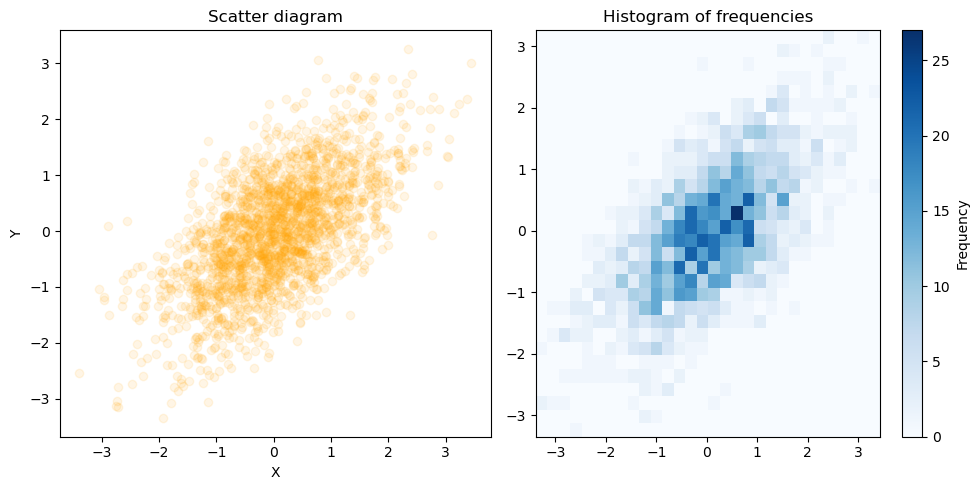

In [9]:
ro = 0.6
n = 2000

mean = [0, 0]
cov_matrix = [[1, ro], [ro, 1]]
X, Y = np.random.multivariate_normal(mean, cov_matrix, n).T

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X, Y, alpha=0.1, color='orange')
plt.title('Scatter diagram')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
hist, xedges, yedges = np.histogram2d(X, Y, bins=30)
plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
plt.colorbar(label='Frequency')
plt.title('Histogram of frequencies')

plt.tight_layout()
plt.show()

Генеруємо точки з двовимірного нормального розподілу. \
Відображаємо діаграму розсіяння для цих точок і будуємо двовимірну. Гістограма вказує на частоту точок у різних інтервалах.

### Завдання 7, лекція 6

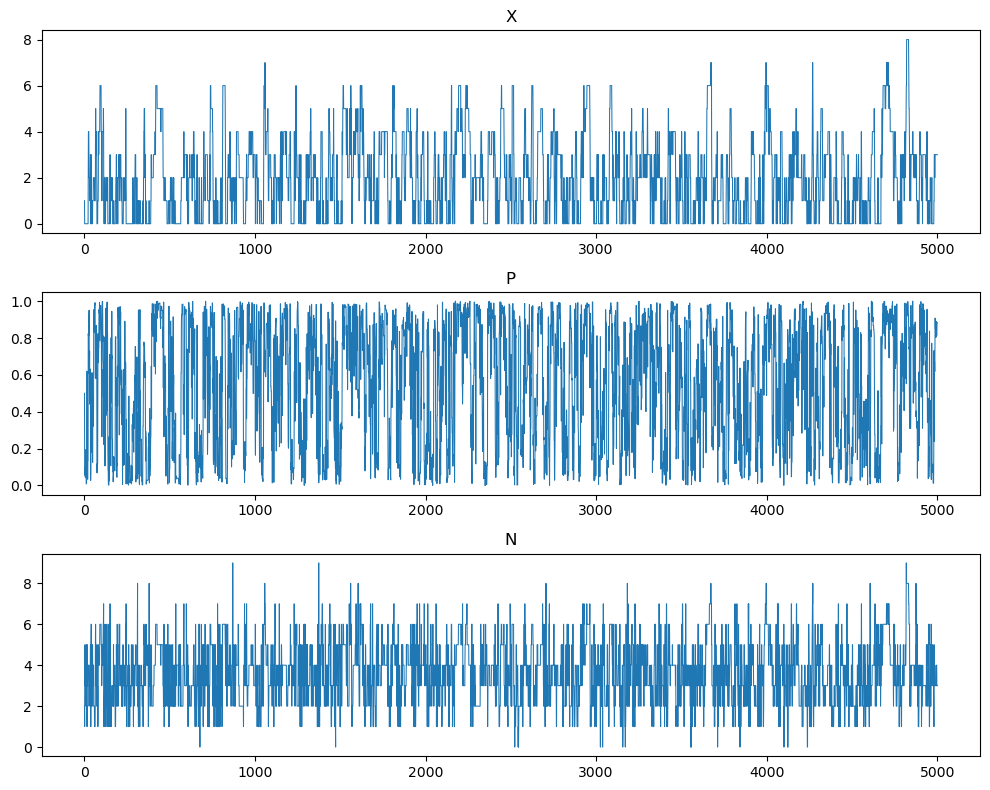

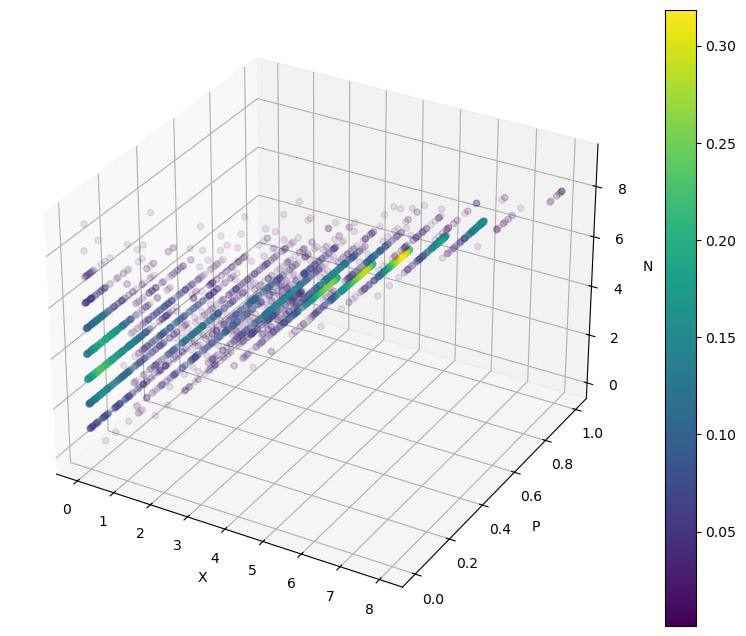

In [10]:
def XPN_distr_model(x0, p0, n0, m):
    X = np.zeros(m, dtype=int)
    P = np.zeros(m)
    N = np.zeros(m, dtype=int)
    
    X[0], P[0], N[0] = x0, p0, n0
    
    for i in range(1, m):
        x_new = np.random.binomial(N[i - 1], P[i - 1])
        p_new = beta.rvs(x_new + 1, N[i - 1] - x_new + 1)
        n_new = poisson.rvs(4 * (1 - p_new)) + x_new
        
        alpha_f = f_xpn(x_new, p_new, n_new) / f_xpn(X[i - 1], P[i - 1], N[i - 1])
        u = np.random.rand()
        
        if u <= alpha_f:
            X[i], P[i], N[i] = x_new, p_new, n_new
        else:
            X[i], P[i], N[i] = X[i - 1], P[i - 1], N[i - 1]
    
    return X, P, N

def f_xpn(x, p, n):
    C_xn = comb(n, x)
    return C_xn * p**x * (1 - p)**(n - x) * 4**n / factorial(n)

def show_xpn(X, P, N):
    data = np.vstack([X, P, N])
    kde = gaussian_kde(data)
    density = kde(data)
    
    norm = Normalize(vmin=density.min(), vmax=density.max())
    density = norm(density)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X, P, N, c=density, alpha=0.1, cmap='viridis')
    
    sm = ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array(density)
    
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    ax.set_zlabel('N')

    fig.colorbar(sm, ax=ax)
    
    plt.show()

def show_xpn_three_v(X, P, N):
    m = len(X)
    plt.figure(figsize=(10, 8))
    
    plt.subplot(3, 1, 1)
    plt.plot(np.arange(1, m + 1), X, linewidth=0.75)
    plt.title('X')
    
    plt.subplot(3, 1, 2)
    plt.plot(np.arange(1, m + 1), P, linewidth=0.75)
    plt.title('P')
    
    plt.subplot(3, 1, 3)
    plt.plot(np.arange(1, m + 1), N, linewidth=0.75)
    plt.title('N')
    
    plt.tight_layout()
    plt.show()

x0, p0, n0 = 1, 0.5, 2
m = 5000

X, P, N = XPN_distr_model(x0, p0, n0, m)

show_xpn_three_v(X, P, N)
show_xpn(X, P, N)

### Завдання 8, лекція 6

Number of visits to each state:
1257
1365
1262
1284
1178
1323
1191
1141


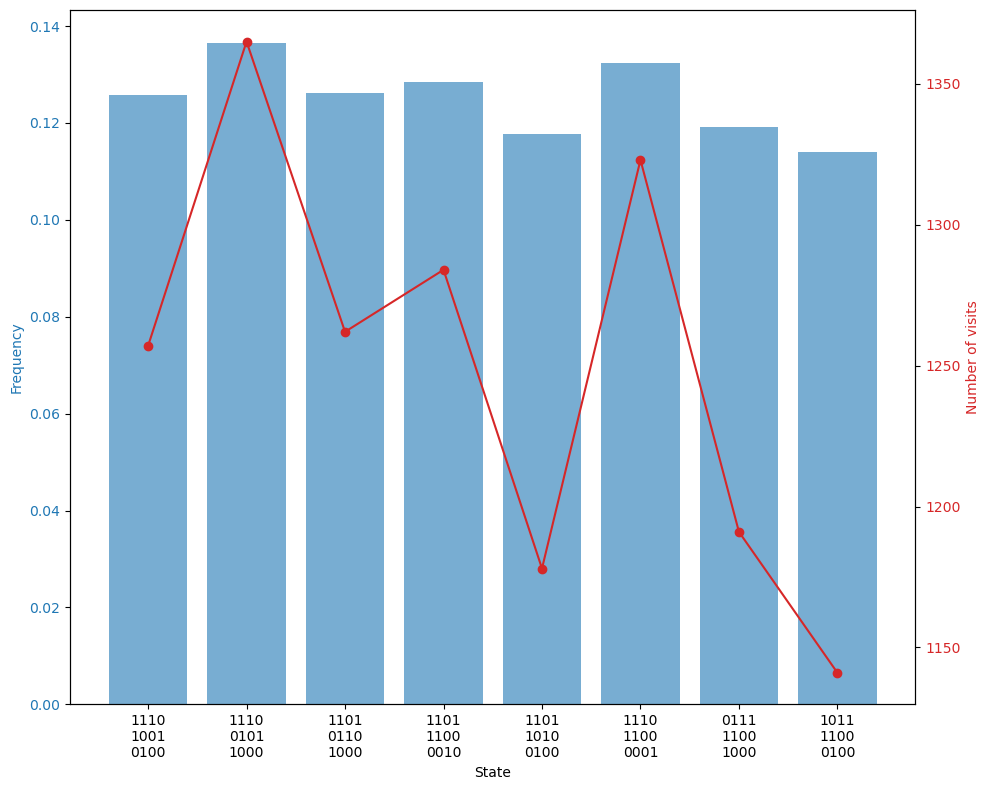

In [11]:
def generate_binary_matrix(r, c):
    rows = len(r)
    cols = len(c)
    matrix = [[0] * cols for _ in range(rows)]
    
    for i in range(rows):
        while sum(matrix[i]) < r[i]:
            j = random.randint(0, cols - 1)
            if matrix[i][j] == 0:
                matrix[i][j] = 1
    
    for j in range(cols):
        while sum(matrix[i][j] for i in range(rows)) < c[j]:
            i = random.randint(0, rows - 1)
            if matrix[i][j] == 0:
                matrix[i][j] = 1
    
    return matrix

def is_valid_matrix(matrix, r, c):
    if len(matrix) != len(r) or len(matrix[0]) != len(c):
        return False
    
    for i, row in enumerate(matrix):
        if sum(row) != r[i]:
            return False
    
    for j in range(len(matrix[0])):
        if sum(matrix[i][j] for i in range(len(matrix))) != c[j]:
            return False
    
    return True

def bin_matrix(r, c):
    while True:
        matrix = generate_binary_matrix(r, c)
        if is_valid_matrix(matrix, r, c):
            return matrix

def create_checkerboard(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    
    selected_rows = sorted(random.sample(range(rows), 2))
    selected_cols = sorted(random.sample(range(cols), 2))

    if matrix[selected_rows[0]][selected_cols[0]] == matrix[selected_rows[1]][selected_cols[1]] and \
        matrix[selected_rows[1]][selected_cols[0]] == matrix[selected_rows[0]][selected_cols[1]] and \
        matrix[selected_rows[1]][selected_cols[0]] != matrix[selected_rows[0]][selected_cols[0]]:
        
        matrix[selected_rows[0]][selected_cols[0]] = 1 - matrix[selected_rows[0]][selected_cols[0]]
        matrix[selected_rows[1]][selected_cols[1]] = 1 - matrix[selected_rows[1]][selected_cols[1]]
        matrix[selected_rows[1]][selected_cols[0]] = 1 - matrix[selected_rows[1]][selected_cols[0]]
        matrix[selected_rows[0]][selected_cols[1]] = 1 - matrix[selected_rows[0]][selected_cols[1]]
    
    return matrix

def BinTables(r, c, n_iterations=10**4):
    samples = []
    rows = len(r)
    cols = len(c)
    
    current_state = bin_matrix(r, c)
    samples.append(np.array(current_state))
    current_iteration = 0
    
    while current_iteration < n_iterations:
        current_state = create_checkerboard(current_state)
        samples.append(np.array(current_state))
        current_iteration += 1
    
    return samples

def frequency_count(samples):
    n = len(samples)
    states = {}
    
    for sample in samples:
        state_tuple = tuple(map(tuple, sample))
        if state_tuple in states:
            states[state_tuple] += 1
        else:
            states[state_tuple] = 1
    
    frequencies = {state: count / n for state, count in states.items()}
    
    return frequencies, states

def plot_frequencies(frequencies, state_counts):
    states = list(frequencies.keys())
    freq_values = list(frequencies.values())
    counts = [state_counts[state] for state in states]
    
    state_labels = ['\n'.join([''.join(map(str, row)) for row in state]) for state in states]
    
    x = np.arange(len(states))
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('State')
    ax1.set_ylabel('Frequency', color=color)
    ax1.bar(x, freq_values, color=color, alpha=0.6, label='Frequency')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Number of visits', color=color)
    ax2.plot(x, counts, color=color, marker='o', label='Visiting')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.xticks(x, state_labels, rotation=90)
    fig.tight_layout()  
    plt.show()

r = [3, 2, 1]
c = [2, 2, 1, 1]

samples = BinTables(r, c)

frequencies, state_counts = frequency_count(samples)

print('Number of visits to each state:')
for state, count in state_counts.items():
    print(count)

plot_frequencies(frequencies, state_counts)